In [141]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mpld3

import rain

In [142]:
mpld3.disable_notebook()
#mpld3.enable_notebook()

In [143]:
df = pd.read_csv(rain.toRelPath("data/df-cache.csv"))

mid = df["mid"]

In [144]:
def portfolioToValue(fees, mid, portfolio):
    midShift = mid.shift(-1)
    rMid = midShift / mid
    rValue = portfolio * rMid + (1 - portfolio)
    trueValue = rValue.cumprod() * mid[0]
    
    dPortfolio = portfolio.shift(-1) - portfolio
    #percentage fees incurred at each timestep
    dRelValueFees = 1 - dPortfolio.abs() * fees
    #value with fees relative to value without fees
    relValueFees = dRelValueFees.cumprod()
    return relValueFees * trueValue

In [145]:
def mvacToPortfolio(shortPeriod, longPeriod, mid, actionThreshold, hyperbolic = False):
    mvAve = [mid.rolling(shortPeriod).mean(), mid.rolling(longPeriod).mean()]
    mvDiff = mvAve[1] - mvAve[0]
    stdMvDiff = mvDiff / mvDiff[mvDiff.idxmax()]
    #reduced using threshold
    redStdMvDiff = pd.DataFrame(np.zeros(len(df)))[0]
    redStdMvDiff[stdMvDiff > actionThreshold] = 1
    redStdMvDiff[stdMvDiff < -actionThreshold] = -1
    redStdMvDiff[redStdMvDiff == 0] = None
    threshPort = 1 - (redStdMvDiff.fillna(method = "pad") + 1) / 2
    return threshPort.fillna(value = 0)

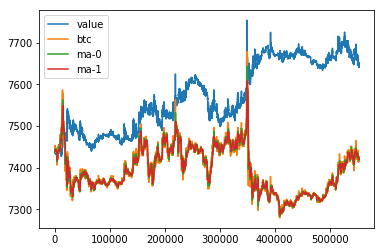

In [146]:
PERIODS = [300, 900]

portfolio = mvacToPortfolio(PERIODS[0], PERIODS[1], mid, 0)
value = portfolioToValue(0, mid, portfolio)

plt.plot(value, label = "value")
plt.plot(mid, label = "btc")
plt.plot(mid.rolling(PERIODS[0]).mean(), label = "ma-0")
plt.plot(mid.rolling(PERIODS[1]).mean(), label = "ma-1")
plt.legend()
plt.show()

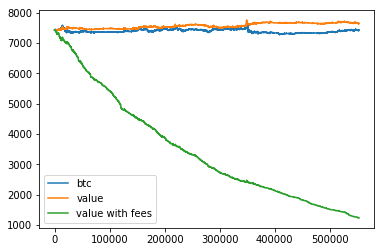

In [147]:
FEE_RATIO = 25 * 1e-4

valueFees = portfolioToValue(FEE_RATIO, mid, portfolio)

plt.plot(mid, label = "btc")
plt.plot(value, label = "value")
plt.plot(valueFees, label = "value with fees")
plt.legend()
plt.show()

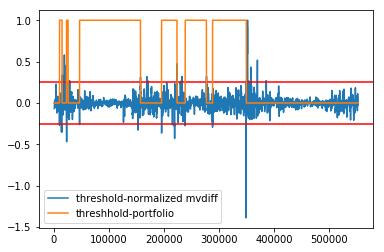

In [148]:
ACTION_THRESHOLD = 2500 * 1e-4

mvDiff = mid.rolling(PERIODS[1]).mean() - mid.rolling(PERIODS[0]).mean()
threshPort = mvacToPortfolio(PERIODS[0], PERIODS[1], mid, ACTION_THRESHOLD)
plt.plot(mvDiff / mvDiff[mvDiff.idxmax()], 
         label = "threshold-normalized mvdiff")
plt.axhline(y = ACTION_THRESHOLD, color = "r")
plt.axhline(y = -ACTION_THRESHOLD, color = "r")
plt.plot(threshPort, label = "threshhold-portfolio")
plt.legend()
plt.show()

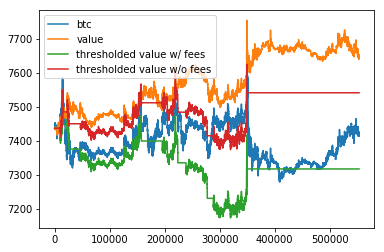

In [149]:
threshValueFees = portfolioToValue(FEE_RATIO, mid, threshPort)

plt.plot(mid, label = "btc")
plt.plot(value, label = "value")
plt.plot(threshValueFees, label = "thresholded value w/ fees")
plt.plot(portfolioToValue(0, mid, threshPort), label = "thresholded value w/o fees")
plt.legend()
plt.show()

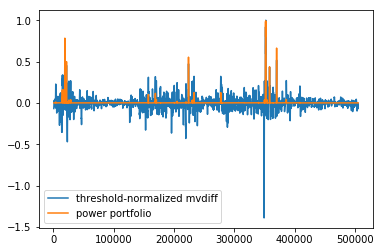

In [137]:
powerMvDiff = np.power(np.tanh(mvDiff / mid[0] * 500), 15)
powerPort = powerMvDiff.copy()
powerPort[powerPort > 0] = powerPort * 999
powerPort = (powerPort + 1) / 1000
plt.plot(mvDiff / mvDiff[mvDiff.idxmax()], 
         label = "threshold-normalized mvdiff")
plt.plot(powerPort, label = "power portfolio")
plt.legend()
plt.show()

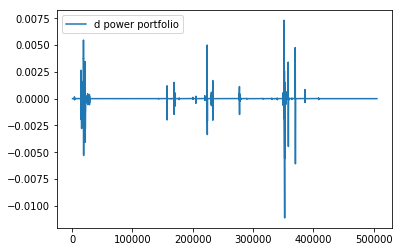

Power portfolio adjusts: 10.99389982346105
Portfolio adjusts: 651.0
Threshold portfolio adjusts: 12.0


In [138]:
dPowerPort = powerPort.shift(-1) - powerPort
dPortfolio = portfolio.shift(-1) - portfolio
dThreshPort = threshPort.shift(-1) - threshPort
plt.plot(dPowerPort, label = "d power portfolio")
plt.legend()
plt.show()
print("Power portfolio adjusts:", np.sum(dPowerPort.abs()))
print("Portfolio adjusts:", np.sum(dPortfolio.abs()))
print("Threshold portfolio adjusts:", np.sum(dThreshPort.abs()))

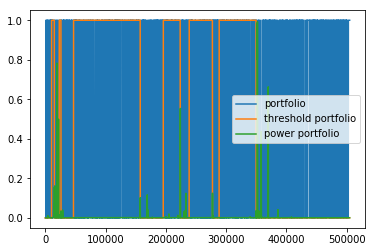

In [139]:
plt.plot(portfolio, label = "portfolio")
plt.plot(threshPort, label = "threshold portfolio")
plt.plot(powerPort, label = "power portfolio")
plt.legend()
plt.show()

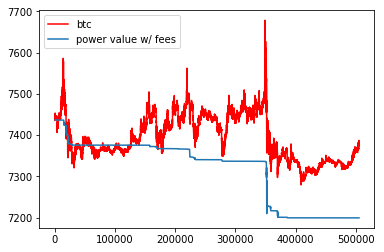

In [140]:
plt.plot(mid, label = "btc", c = "r")
#plt.plot(portfolioToValue(FEE_RATIO, mid, portfolio), label = "value w/ fees")
#plt.plot(portfolioToValue(FEE_RATIO, mid, threshPort), label = "thresh value w/ fees")
plt.plot(portfolioToValue(FEE_RATIO, mid, powerPort), label = "power value w/ fees")
plt.legend()
plt.show()